# Bass Matching Demo

This notebook demonstrates the `percent_bass_pc_match` function from `music_df.harmony.matching`.

The function calculates how often the lowest pitch at each onset matches the expected bass pitch class (the first character of the `chord_pcs` hex string). This is useful for evaluating whether a passage is in root position or inverted.

In [1]:
# Use local music_df from this worktree instead of the installed version
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

In [2]:
import tempfile
from pathlib import Path

import verovio
from IPython.display import SVG, display
import pandas as pd

from music_df.read_krn import read_krn
from music_df.harmony.matching import percent_bass_pc_match

In [3]:
def show_notation(data: str, width=1200, height=800, scale=50, input_format="auto") -> None:
    """Display music notation inline in Jupyter."""
    tk = verovio.toolkit()
    
    options = {
        "pageWidth": width,
        "pageHeight": height,
        "scale": scale,
        "adjustPageHeight": True,
    }
    if input_format != "auto":
        options["inputFrom"] = input_format
    
    tk.setOptions(options)
    tk.loadData(data)
    
    for page in range(1, tk.getPageCount() + 1):
        display(SVG(tk.renderToSVG(page)))


def parse_humdrum_string(humdrum: str) -> pd.DataFrame:
    """Parse a Humdrum string by writing to a temp file and using read_krn."""
    with tempfile.NamedTemporaryFile(mode="w", suffix=".krn", delete=False) as f:
        f.write(humdrum)
        temp_path = f.name
    try:
        return read_krn(temp_path)
    finally:
        Path(temp_path).unlink()

## Example 1: Root Position Chords (100% bass match)

C major and G major triads in root position. The bass notes (C=0, G=7) match the chord roots.

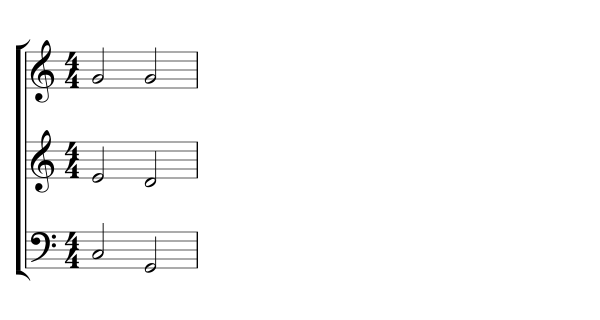

In [4]:
humdrum1 = """**kern\t**kern\t**kern
*clefF4\t*clefG2\t*clefG2
*M4/4\t*M4/4\t*M4/4
=1\t=1\t=1
2C\t2e\t2g
2GG\t2d\t2g
=2\t=2\t=2
*-\t*-\t*-
"""

show_notation(humdrum1)

In [5]:
df1 = parse_humdrum_string(humdrum1)
notes1 = df1[df1["type"] == "note"][["onset", "release", "pitch", "spelling"]]
print("Music DataFrame (notes only):")
print("  First chord: C3 (48), E4 (64), G4 (67)")
print("  Second chord: G2 (43), D4 (62), G4 (67)")
display(notes1)

Music DataFrame (notes only):
  First chord: C3 (48), E4 (64), G4 (67)
  Second chord: G2 (43), D4 (62), G4 (67)


,onset,release,pitch,spelling
3,0,2.0,48.0,C
4,0,2.0,64.0,E
5,0,2.0,67.0,G
6,2,4.0,43.0,G
7,2,4.0,62.0,D
8,2,4.0,67.0,G


In [6]:
chord_df1 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # C major (C-E-G), G major (G-B-D)
})
print("Chord DataFrame:")
print("  chord_pcs '047' = C major (0=C, 4=E, 7=G), expected bass PC = 0")
print("  chord_pcs '72B' = G major (7=G, B=11=B, 2=D), expected bass PC = 7")
display(chord_df1)

Chord DataFrame:
  chord_pcs '047' = C major (0=C, 4=E, 7=G), expected bass PC = 0
  chord_pcs '72B' = G major (7=G, B=11=B, 2=D), expected bass PC = 7


,onset,release,chord_pcs
0,0.0,2.0,047
1,2.0,4.0,72B


In [7]:
result1 = percent_bass_pc_match(df1, chord_df1)
print(f"Macroaverage: {result1['macroaverage']}")
print(f"Microaverage: {result1['microaverage']}")

assert result1["macroaverage"] == 1.0, f"Expected 1.0, got {result1['macroaverage']}"
assert result1["microaverage"] == 1.0, f"Expected 1.0, got {result1['microaverage']}"
print("\nBoth averages are 1.0: all bass notes match their expected pitch classes.")

Macroaverage: 1.0
Microaverage: 1.0

Both averages are 1.0: all bass notes match their expected pitch classes.


## Example 2: Inverted Chords (0% bass match)

Same C major and G major triads, but in first inversion. The bass notes (E=4, B=11) don't match the chord roots (0, 7).

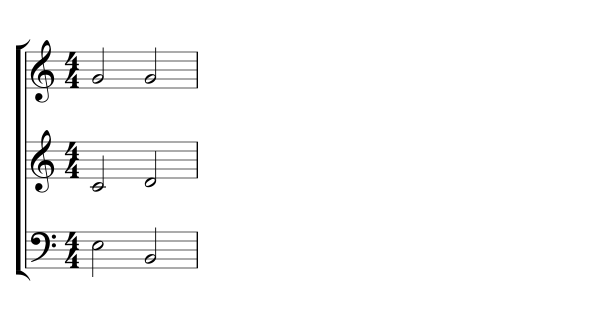

In [8]:
humdrum2 = """**kern\t**kern\t**kern
*clefF4\t*clefG2\t*clefG2
*M4/4\t*M4/4\t*M4/4
=1\t=1\t=1
2E\t2c\t2g
2BB\t2d\t2g
=2\t=2\t=2
*-\t*-\t*-
"""

show_notation(humdrum2)

In [9]:
df2 = parse_humdrum_string(humdrum2)
notes2 = df2[df2["type"] == "note"][["onset", "release", "pitch", "spelling"]]
print("Music DataFrame (notes only):")
print("  First chord: E3 (52), C4 (60), G4 (67) - C major in 1st inversion")
print("  Second chord: B2 (47), D4 (62), G4 (67) - G major in 1st inversion")
display(notes2)

Music DataFrame (notes only):
  First chord: E3 (52), C4 (60), G4 (67) - C major in 1st inversion
  Second chord: B2 (47), D4 (62), G4 (67) - G major in 1st inversion


,onset,release,pitch,spelling
3,0,2.0,52.0,E
4,0,2.0,60.0,C
5,0,2.0,67.0,G
6,2,4.0,47.0,B
7,2,4.0,62.0,D
8,2,4.0,67.0,G


In [10]:
chord_df2 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # Same chords, but music is inverted
})
print("Chord DataFrame (same as Example 1):")
print("  Expected bass PCs are still 0 (C) and 7 (G)")
print("  But actual bass notes are E (PC=4) and B (PC=11)")
display(chord_df2)

Chord DataFrame (same as Example 1):
  Expected bass PCs are still 0 (C) and 7 (G)
  But actual bass notes are E (PC=4) and B (PC=11)


,onset,release,chord_pcs
0,0.0,2.0,047
1,2.0,4.0,72B


In [11]:
result2 = percent_bass_pc_match(df2, chord_df2)
print(f"Macroaverage: {result2['macroaverage']}")
print(f"Microaverage: {result2['microaverage']}")

assert result2["macroaverage"] == 0.0, f"Expected 0.0, got {result2['macroaverage']}"
assert result2["microaverage"] == 0.0, f"Expected 0.0, got {result2['microaverage']}"
print("\nBoth averages are 0.0: no bass notes match their expected pitch classes.")

Macroaverage: 0.0
Microaverage: 0.0

Both averages are 0.0: no bass notes match their expected pitch classes.


## Example 3: Mixed (Partial match)

First chord in root position, second chord inverted. Demonstrates partial matching.

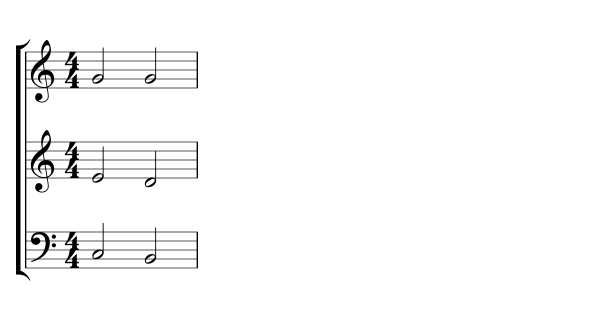

In [12]:
humdrum3 = """**kern\t**kern\t**kern
*clefF4\t*clefG2\t*clefG2
*M4/4\t*M4/4\t*M4/4
=1\t=1\t=1
2C\t2e\t2g
2BB\t2d\t2g
=2\t=2\t=2
*-\t*-\t*-
"""

show_notation(humdrum3)

In [13]:
df3 = parse_humdrum_string(humdrum3)
notes3 = df3[df3["type"] == "note"][["onset", "release", "pitch", "spelling"]]
print("Music DataFrame (notes only):")
print("  First chord: C3 (48), E4 (64), G4 (67) - C major root position")
print("  Second chord: B2 (47), D4 (62), G4 (67) - G major 1st inversion")
display(notes3)

Music DataFrame (notes only):
  First chord: C3 (48), E4 (64), G4 (67) - C major root position
  Second chord: B2 (47), D4 (62), G4 (67) - G major 1st inversion


,onset,release,pitch,spelling
3,0,2.0,48.0,C
4,0,2.0,64.0,E
5,0,2.0,67.0,G
6,2,4.0,47.0,B
7,2,4.0,62.0,D
8,2,4.0,67.0,G


In [14]:
chord_df3 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],
})
print("Chord DataFrame:")
print("  First chord: bass C (PC=0) matches expected PC=0")
print("  Second chord: bass B (PC=11) doesn't match expected PC=7")
display(chord_df3)

Chord DataFrame:
  First chord: bass C (PC=0) matches expected PC=0
  Second chord: bass B (PC=11) doesn't match expected PC=7


,onset,release,chord_pcs
0,0.0,2.0,047
1,2.0,4.0,72B


In [15]:
result3 = percent_bass_pc_match(df3, chord_df3)
print(f"Macroaverage: {result3['macroaverage']}")
print(f"Microaverage: {result3['microaverage']}")

assert result3["macroaverage"] == 0.5, f"Expected 0.5, got {result3['macroaverage']}"
assert result3["microaverage"] == 0.5, f"Expected 0.5, got {result3['microaverage']}"
print("\nBoth averages are 0.5: one of two bass notes matches.")

Macroaverage: 0.5
Microaverage: 0.5

Both averages are 0.5: one of two bass notes matches.


## Example 4: Duration Weighting

This example shows how `weight_by_duration=True` (the default) gives more weight to longer bass notes.

We have two bass notes within a single chord:
- C (matching) held for 3 beats
- D (non-matching) held for 1 beat

With duration weighting: 3/(3+1) = 0.75
Without duration weighting: 1/2 = 0.5

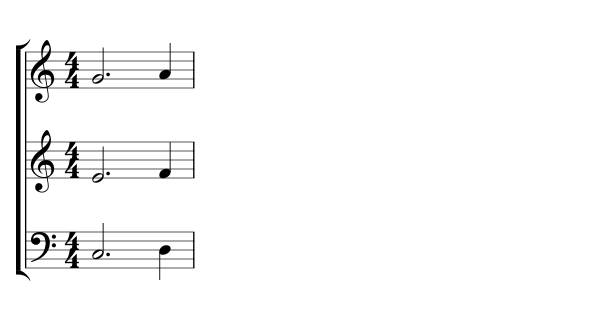

In [16]:
humdrum4 = """**kern\t**kern\t**kern
*clefF4\t*clefG2\t*clefG2
*M4/4\t*M4/4\t*M4/4
=1\t=1\t=1
2.C\t2.e\t2.g
4D\t4f\t4a
=2\t=2\t=2
*-\t*-\t*-
"""

show_notation(humdrum4)

In [17]:
df4 = parse_humdrum_string(humdrum4)
notes4 = df4[df4["type"] == "note"][["onset", "release", "pitch", "spelling"]]
print("Music DataFrame (notes only):")
print("  Beat 0-3: C3 (48), E4 (64), G4 (67) - C major triad")
print("  Beat 3-4: D3 (50), F4 (65), A4 (69) - D minor triad")
display(notes4)

Music DataFrame (notes only):
  Beat 0-3: C3 (48), E4 (64), G4 (67) - C major triad
  Beat 3-4: D3 (50), F4 (65), A4 (69) - D minor triad


,onset,release,pitch,spelling
3,0,3.0,48.0,C
4,0,3.0,64.0,E
5,0,3.0,67.0,G
6,3,4.0,50.0,D
7,3,4.0,65.0,F
8,3,4.0,69.0,A


In [18]:
chord_df4 = pd.DataFrame({
    "onset": [0.0],
    "release": [4.0],
    "chord_pcs": ["047"],  # C major, expected bass PC = 0
})
print("Chord DataFrame:")
print("  Single C major chord spanning the whole measure")
print("  Bass notes: C (duration=3, matches) and D (duration=1, doesn't match)")
display(chord_df4)

Chord DataFrame:
  Single C major chord spanning the whole measure
  Bass notes: C (duration=3, matches) and D (duration=1, doesn't match)


,onset,release,chord_pcs
0,0.0,4.0,047


In [19]:
result4_weighted = percent_bass_pc_match(df4, chord_df4, weight_by_duration=True)
result4_unweighted = percent_bass_pc_match(df4, chord_df4, weight_by_duration=False)

print("With duration weighting (default):")
print(f"  Macroaverage: {result4_weighted['macroaverage']}")
print(f"  Microaverage: {result4_weighted['microaverage']}")

print("\nWithout duration weighting:")
print(f"  Macroaverage: {result4_unweighted['macroaverage']}")
print(f"  Microaverage: {result4_unweighted['microaverage']}")

assert result4_weighted["microaverage"] == 0.75, f"Expected 0.75, got {result4_weighted['microaverage']}"
assert result4_unweighted["microaverage"] == 0.5, f"Expected 0.5, got {result4_unweighted['microaverage']}"

print("\nThe longer C note (3 beats) gets more weight than the shorter D note (1 beat).")

With duration weighting (default):
  Macroaverage: 0.75
  Microaverage: 0.75

Without duration weighting:
  Macroaverage: 0.5
  Microaverage: 0.5

The longer C note (3 beats) gets more weight than the shorter D note (1 beat).


## Examining the Match Column

The function also adds a match column to the DataFrame showing which bass notes matched.

In [20]:
result_df = result4_weighted["music_df"]
notes_with_match = result_df[result_df["type"] == "note"][["onset", "release", "pitch", "spelling", "is_bass_match"]]
print("Notes with bass match column:")
print("  - True: this bass note's PC matches the expected bass PC")
print("  - False: this bass note's PC doesn't match")
print("  - <NA>: not a bass note (not the lowest pitch at this onset)")
display(notes_with_match)

Notes with bass match column:
  - True: this bass note's PC matches the expected bass PC
  - False: this bass note's PC doesn't match
  - <NA>: not a bass note (not the lowest pitch at this onset)


,onset,release,pitch,spelling,is_bass_match
3,0,3.0,48.0,C,False
4,0,3.0,64.0,E,<NA>
5,0,3.0,67.0,G,<NA>
6,3,4.0,50.0,D,<NA>
7,3,4.0,65.0,F,<NA>
8,3,4.0,69.0,A,<NA>
